# Figures

This notebook shows how to reproduce the figures in the manuscript, using the results from the
corresponding folder in the repository.

Check out the file `main_estimate_postprocess.py` to see how these results were derived.

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('utils/')
from utils_plotting import updaterc, cm_to_inch
import matplotlib.gridspec as gridspec
import os
from scipy.special import logsumexp

In [2]:
# Specify paths to the corresponding folders
path_data_intro = os.path.join(os.getcwd() + os.sep + 'data' + os.sep)
path_data = os.path.join(os.getcwd() + os.sep + 'data' + os.sep
    + 'ngawest2' + os.sep)
path_res_params = os.path.join(os.getcwd() + os.sep + 'results' + os.sep
    + 'PosteriorParameters' + os.sep)
path_res_is = os.path.join(os.getcwd() + os.sep + 'results' + os.sep
    + 'PostProcessed' + os.sep + 'in_sample' + os.sep)
path_res_oos = os.path.join(os.getcwd() + os.sep + 'results' + os.sep
    + 'PostProcessed' + os.sep + 'out_of_sample' + os.sep)
path_res_casestudy = os.path.join(os.getcwd() + os.sep + 'results' + os.sep
    + 'CaseStudy' + os.sep )

## Figure 1

Illustration of the proposed spatial correlation models: 

Top row (from left to right): Euclidean and angular distance and dissimilarity  metrics $d_{\mathrm{E}}$, $d_{\mathrm{A}}$, and $d_{\mathrm{S}}$ that serve as dependent variables; Individual models E, A and S as a function of the corresponding dependendent variable for different parameter values. 

Bottom row (from left to right): Soil conditions in a fictitious 30x30km region that are used to illustrate correlation coefficients with respect to the indicated reference site for the combined correlation models E, EA and EAS, where the model parameters are set to their corresponding prior mean values. 

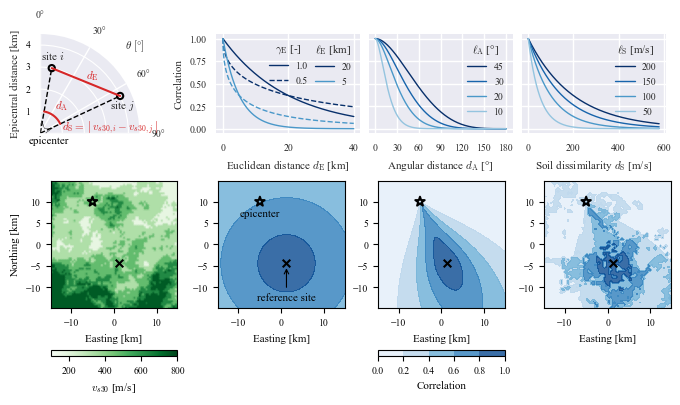

In [3]:
from utils_plotting import fig1_a_to_d, fig1_e_to_h

plt.style.use(['seaborn-v0_8'])
updaterc()
figsize = cm_to_inch((17.0,10))
fig = plt.figure(constrained_layout=True, figsize=figsize)
gs0 = gridspec.GridSpec(2, 1, figure=fig, 
    height_ratios= [1, 1.3], hspace= 0.07)

# ---------
# Top row
# ---------
gs00 = gs0[0].subgridspec(1, 4)

# Specify parameters of individual functions
psi_E = dict(LE=[20, 5], gammaE=[1.0, 0.5])
psi_A = dict(LA=[45, 30, 20, 10])
psi_S = dict(LS=[200, 150, 100, 50])

fig1_a_to_d(fig, gs00, psi_E, psi_A, psi_S)

# ---------
# Bottom row
# ---------

from models_numpy import rhoE, rhoEA, rhoEAS

# load fictitious soil conditions 
df = pd.read_csv(path_data_intro + 'intro_virtualregion.csv')

# Specify parameter sets 
# Feel free to change these to play around!
psi_E = dict(LE=30.0, gammaE=1.0)
psi_EA = dict(LE=30.0, gammaE=1.0, LA=18.0)
psi_EAS = dict(LE=30.0, gammaE=1.0, LA=18.0, LS=100.0, w=0.50)

# Store input matrix X
X = df[['epi_dist', 'epi_azimuth', 'vs30']].values

# index of reference site
ref_idx = 1990

# Compute correlations
kE = rhoE(X, **psi_E)[ref_idx, :]
kEA = rhoEA(X, **psi_EA)[ref_idx, :]
kEAS = rhoEAS(X, **psi_EAS)[ref_idx, :]

# Plot
plt.style.use(['default'])
updaterc()
gs01 = gs0[1].subgridspec(2, 4, height_ratios= [7, 0.3], hspace= 0.02)
fig1_e_to_h(fig, gs01, df, ref_idx, kE, kEA, kEAS)

## Figure 2

Illustration of the used pooled training data set.

Number of station pairs in joint bins of Euclidean and angular distance (left), and Euclidean
distance and soil dissimilarity in (right). Note the logarithmic color scale.

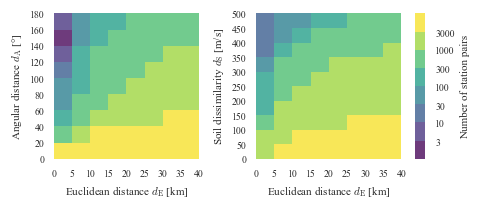

In [4]:
# Import training data for Sa(T=1s)
df = pd.read_csv(path_data + 'data_ngawest2_T100.csv')

# Specify bins
bin_s = [(i, i+50) for i in np.arange(0,500,50)]
bin_a = [(i, i+20) for i in np.arange(0,180,20)]
bin_e = [(i, i+5) for i in np.arange(0,40,5)]

# Functions to count pairs per bin for a specific event
from utils_plotting import get_npairs_angeucl, get_npairs_vs30eucl

# Loop over all events
nP_ES = np.zeros((len(bin_e), len(bin_s)))
nP_EA = np.zeros((len(bin_e), len(bin_a)))
for _, group in df.groupby('eqid'):
    Xtest = group[['epi_dist', 'epi_azimuth', 'vs30']].values
    nP_ES += get_npairs_vs30eucl(Xtest, bin_s, bin_e).astype(int)
    nP_EA += get_npairs_angeucl(Xtest, bin_a, bin_e).astype(int)

from utils_plotting import fig2    

plt.style.use(['seaborn-v0_8'])
updaterc()
figsize = cm_to_inch((0.7*17.0, 5))
fig, axs = plt.subplots(1,3,constrained_layout=True, figsize=figsize,
    gridspec_kw={"width_ratios":[1, 1, 0.075]})
fig2(fig, axs, bin_e, bin_a, bin_s, nP_ES, nP_EA)

## Figure 3

Isotropic model E estimated separately for three events with increasing number of records.

Top row: Posterior distributions of the parameters

Bottom row: Predicted correlation coefficient as a function of Euclidean distance for all posterior parameter samples.

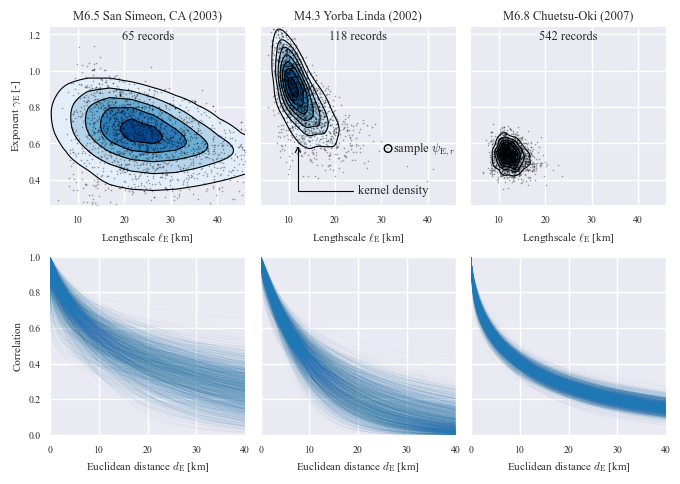

In [5]:
eqids = [177, 167, 278]
titles = [['M6.5 San Simeon, CA (2003)', 'M4.3 Yorba Linda (2002)', 
    'M6.8 Chuetsu-Oki (2007)'],
    ['65 records', '118 records', '542 records']]
# Load the dataframes that contain the posterior parameter samples
dfs_es_single = [pd.read_csv(path_res_is + 'LogLik_EventSpecific_eqid' + 
    str(eqid) + '_EventSpecific_T100.csv') for eqid in eqids]

from utils_plotting import fig3
figsize = cm_to_inch((17.0,12))
fig, axss = plt.subplots(2,3,constrained_layout=True, figsize=figsize, sharey='row')
fig3(axss, dfs_es_single, titles)

## Table 2

Parameters for the different correlation models estimated from the pooled training data set. Stated quantities are the mean, and the 5% and 95% quantiles from the posterior samples.

In [6]:
# Load parameters
dfE = pd.read_csv(path_res_params + 'PostParam_Pooled_T100_E.csv')
dfEA = pd.read_csv(path_res_params + 'PostParam_Pooled_T100_EA.csv')
dfEAS = pd.read_csv(path_res_params + 'PostParam_Pooled_T100_EAS.csv')

names = ['',r'$\ell_{\mathrm{E}}$',
    r'$\gamma_{\mathrm{E}}$',
    r'$\ell_{\mathrm{A}}$',
    r'$\ell_{\mathrm{S}}$',
    r'$w$']

indices = np.hstack([['Mean', '5%, 95% quantiles'] 
     for i in range(3)])
cols = dfEAS.columns
df = pd.DataFrame(columns=names,
    data = np.ones((6,6))*np.nan,
    dtype='object')
r_digits = [1, 2, 1, 1, 2]
df.iloc[:, 0] = indices

for i, col in enumerate(cols):
    c = 0
    for dft in [dfE, dfEA, dfEAS]:
        if np.isin(col, dft.columns):
            me = np.mean(dft[col])
            qs = tuple(np.quantile(dft[col], 
                    [0.05, 0.95]))
            df.iloc[c, i+1] = np.round(me,r_digits[i])
            df.iloc[c+1, i+1] = np.round(qs,r_digits[i])
        c += 2

# df = df.set_index(indices)
df = df.set_index(np.array(['Model E', '', 'Model EA', '', 'Model EAS', '']))
df = df.fillna('-')
df

,,$\ell_{\mathrm{E}}$,$\gamma_{\mathrm{E}}$,$\ell_{\mathrm{A}}$,$\ell_{\mathrm{S}}$,$w$
Model E,Mean,16.0,0.4,-,-,-
,"5%, 95% quantiles","[14.7, 17.4]","[0.38, 0.42]",-,-,-
Model EA,Mean,21.3,0.35,23.6,-,-
,"5%, 95% quantiles","[19.2, 23.5]","[0.33, 0.36]","[20.8, 26.7]",-,-
Model EAS,Mean,29.8,0.41,20.5,169.2,0.7
,"5%, 95% quantiles","[27.0, 32.8]","[0.38, 0.43]","[17.8, 23.6]","[106.1, 250.8]","[0.62, 0.77]"


## Figure 4

Illustration of estimated pooled correlation models E and EAS for $Sa(1s)$.

As a function of Euclidean distance and soil dissimilarity plotted at three angular distances: (left) 5°, (center) 30° and (right) 60°. The shaded area indicates the interval between the 95% and 5% quantile of all sampled functions from the posterior.

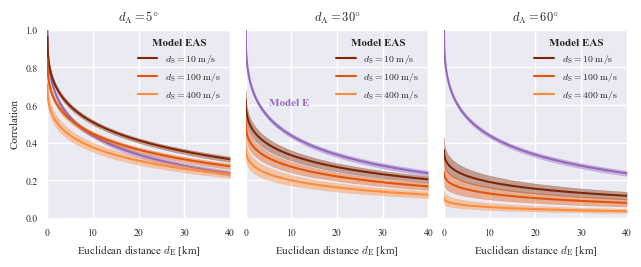

In [7]:
from utils_plotting import fig4

# Load parameters
dfE = pd.read_csv(path_res_params + 'PostParam_Pooled_T100_E.csv')
dfEAS = pd.read_csv(path_res_params + 'PostParam_Pooled_T100_EAS.csv')

dA = [5, 30, 60]
dS = [10, 100, 400]
figsize = cm_to_inch((16.0, 6.5))
fig, axs = plt.subplots(1,3,constrained_layout=True, figsize=figsize, sharey='row')
fig4(axs, dA, dS, dfE, dfEAS)

## Figure 5

Log Posterior Predictive Density (LPPD) for the Hector-Mine earthquake of models E and EAS estimated from the pooled data set,
as well as model E with parameters estimated only from data of this event. The histograms show the log-likelihood of the data conditional on samples from the posterior parameters, $\ln p(\mathcal{D}_k|\boldsymbol{\psi}_{\mathrm{M},r})$ .

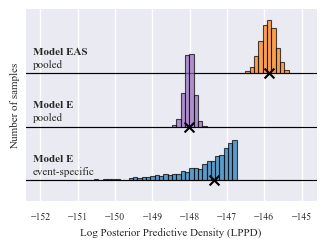

In [8]:
from utils_plotting import fig5
eqid = 158
df_es = pd.read_csv(path_res_is + 'LogLik_EventSpecific_eqid' + 
    str(eqid) + '_EventSpecific_T100.csv')
df_pool = pd.read_csv(path_res_is + 'LogLik_EventSpecific_eqid' + 
    str(eqid) + '_Pooled_T100.csv')
vals = [df_es['loglik'].values, df_pool['E'].values,
    df_pool['EAS'].values]
# Compute LPPD for each model
lppd = [-np.log(len(val)) + logsumexp(val) for val in vals]

figsize = cm_to_inch((8, 6))
fig, ax = plt.subplots(constrained_layout=True, figsize=figsize)
fig5(ax, vals, lppd)

## Figure 6

Relative difference in Log Posterior Predictive Density (LPPD) of pooled model E (left) and EAS (right) to the LPPD of event-specific models E as a function of the available number of records and magnitude. Each point represents one event in the considered data set, and the coloring indicates the event’s magnitude. Positive values indicate higher predictive accuracy (higher LPPD) of the pooled model for this event compared to the corresponding event-specific model E.

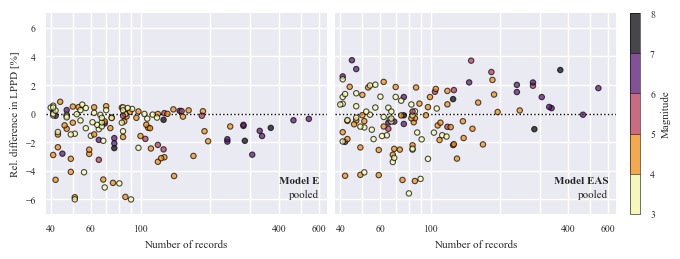

In [9]:
from utils_plotting import fig6
df_es = pd.read_csv(path_res_is + 'LPPD_EventSpecific_EventSpecific_T100.csv')
df_pool = pd.read_csv(path_res_is + 'LPPD_EventSpecific_Pooled_T100.csv')

ms = ['E', 'EAS']

# Compute relative difference to event-specifc model
vals = [(1 - df_pool[m] / df_es['E'])*100 for m in ms]
mags = df_pool.magnitude.values
num_recs = df_pool.num_recs.values

figsize = cm_to_inch((17.0, 6.3))
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=figsize,
    sharex=True, sharey=True)
fig6(axs, vals, num_recs, mags)

## Figure 7

For within-event residuals of Sa(T) at different periods T from the NGA-West2 data set: Relative difference in Log
Posterior Predictive Density (LPPD) of pooled models E, EA and EAS to (left) the LPPD of the independent model, and (right) the LPPD of pooled model E.

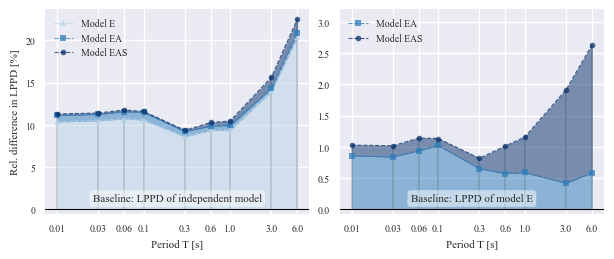

In [10]:
from utils_plotting import fig7
# Load data
df = pd.read_csv(path_res_is + 'LPPD_Pooled_Pooled_Ttot.csv')
periods = df['period'].values
models = ['E', 'EA', 'EAS']
# For subplot (a): Compute relative difference to independent model
valsA = [(1 - df[m] / df['ind'])*100 for m in models]
# For subplot (b): Compute relative difference to model E
valsB = [(1 - df[m] / df['E'])*100 for m in models]

figsize = cm_to_inch((0.9*17.0, 6.3))
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=figsize,
    sharex=True)
fig7(axs, valsA, valsB, models, periods)

## Table 3

In- and out-of-sample performance in terms of relative difference (Eq. 10) in LPPD of pooled models E, EA and EAS to the baseline LPPD of an independent model for the training data (NGA-west2) and test data (Ridgecrest, set 1).

In [11]:
#%% Table 3: In- and Out-of-sample 
df_is = pd.read_csv(path_res_is + 
    'LPPD_Pooled_Pooled_Ttot.csv')
# Extract LPPD of T=1s
df_is = df_is[df_is.period==1].iloc[:,1:].copy()
df_oos = pd.read_csv(path_res_oos + 
    'LPPD_Pooled_set1_Pooled.csv')

models = ['E', 'EA', 'EAS']

vals = []
for df in [df_is, df_oos]:
    vals.append([(1-df[m]/df['ind']).values*100 
        for m in models])
vals = np.squeeze(np.stack(vals)).T

df = pd.DataFrame(data=np.round(vals,2), 
    columns=['In-sample ($\mathcal{D}_{tot}$)', 
             'Out-of-sample ($\tilde{\mathcal{D}}_{1}$)'],
    index=models)
print('Rel. difference in LPPD [%]')
df

Rel. difference in LPPD [%]


,In-sample ($\mathcal{D}_{tot}$),Out-of-sample ($\tilde{\mathcal{D}}_{1}$)
E,9.42,8.32
EA,9.96,8.73
EAS,10.47,10.32


## Figure 8: Bottom row

For the three earthquakes in the second test set ($\tilde{\mathcal{D}}_{2}$) from the 2019 Ridgecrest sequence: The relative difference in Log Posterior Predictive Density (LPPD) of pooled models E and EAS to the baseline LPPD of the independent model.

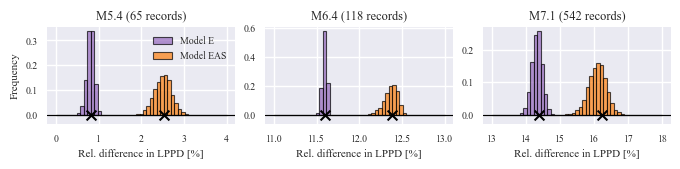

In [12]:
from utils_plotting import fig8
titles = ['M5.4 (65 records)', 'M6.4 (118 records)', 
    'M7.1 (542 records)']

mags = [5.4, 6.4, 7.1] # Magnitudes
dfs = [pd.read_csv(path_res_oos + 
    'loglik_EventSpecific_set2_M' + str(int(mag*10)) + 
    '_Pooled.csv') for mag in mags]
models = ['E', 'EAS']

figsize = cm_to_inch((17, 4))
fig, axs = plt.subplots(1, 3, constrained_layout=True, figsize=figsize)
for i, ax in enumerate(axs):
    # Compute relative difference of Log-Lik. to independent model
    vals = [(1 - dfs[i][m] / dfs[i]['ind'])*100 for m in models]
    # Compute LPPD
    lppd = [-np.log(len(dfs[i])) + 
        logsumexp(dfs[i][m].values) for m in models]
    # Put LPPD relative to independent model
    lppd_rel = [(1 - val / dfs[i]['ind'].values[0])*100 for val in lppd]
    fig8(ax, vals, lppd_rel, models, i)
    ax.set_title(titles[i], fontsize=9)

## Figure 10

Exceedance probability curves for the proportion of sites a in subregion two where $Sa(1s)$ jointly exceeds a threshold value of 0.75g, obtained via: sampling from the posterior predictive distribution of model EAS (dashed line) and sampling conditional on the mean values of the posterior parameter distributions (solid line).

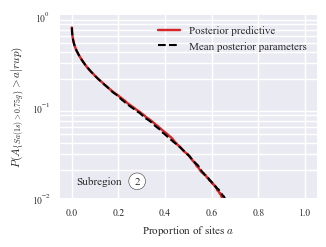

In [13]:
from utils_plotting import ecdf, fig10

dfEAS_mean = pd.read_csv(path_res_casestudy + 
    'PropEx_MeanParam_modelEAS.csv')
dfEAS_marg = pd.read_csv(path_res_casestudy + 
    'PropEx_Marginalized_modelEAS.csv')

# subregion 2 - threshold 0.75g
col = 'sr2_075' 
sim_props = [dfEAS_marg[col].values,
    dfEAS_mean[col].values]

# Compute exceedance probability curve
xaxis = np.linspace(0,1,1000)
vals = [1 - ecdf(sims, xaxis) for sims in sim_props]

figsize = cm_to_inch((8, 6))
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=figsize)
fig10(ax, vals, xaxis)

## Figure 11

Exceedance probability curves for the proportion of sites a in the considered subregions where $Sa(1s)$ jointly exceeds a threshold value $sa$. 

Top row: Subregions one and two (left and center), and for one and two combined (right) using a threshold value of 0.75g.

Bottom row: Subregions three and four separately, (a) and (b), and for three and four combined (c) using a threshold value of 0.25g.

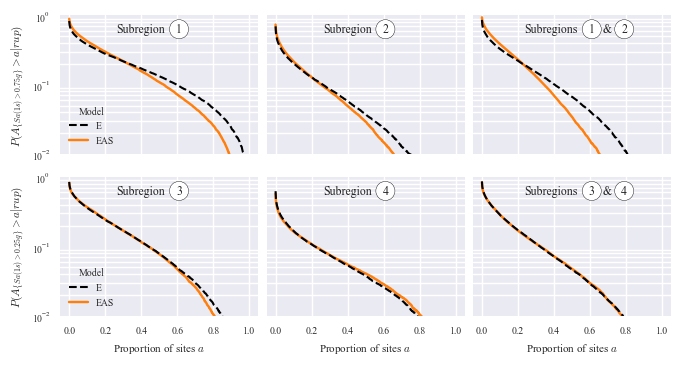

In [14]:
from utils_plotting import fig11
# Specify IM
imstring = 'sa03'
# Import results 
models = ['E', 'EAS']
fnames = ['PropCCDF_MeanParam_model' + m + '_poe010' for m in models]
# Load results
dfs = [pd.read_csv(path_res_casestudy + name + '_' 
                   + imstring + '.csv') for name in fnames]

# Create figure
figsize = cm_to_inch((17.0, 9))
fig, axss = plt.subplots(2, 3, figsize=figsize, sharex=True, sharey=True)
fig11(axss, dfs)
fig.tight_layout()